# FloyHub introduction to Deep Learning: Convolutional Neural Networks

### Abstract

TODO

## Introduction

TODO

#### Table of Contents:
- ...


### Collect a Dataset

For this task we will use the MNIST dataset that we have already uploaded for you as FloydHub dataset. If you have followed the steps in the README.md or in the article, you will be able to load the MNIST dataset from the input path.
First of all we import all the packages we need for running this tutorial:
- `torch`, our DL framework
- `torchvision`, package to handle pytorch Dataset for computer vision task
- `torch.nn`, package we need to create our Models
- `numpy` package to handle vector representation
- `matplotlib` to plot graphs

In [1]:
import torch
import torchvision.datasets as dsets
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# CUDA?
cuda = torch.cuda.is_available()

# Seed for replicability
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision. torchvision.datasets provide a great API to handle the MNIST dataset. The snippet of code below, will create the MNIST dataset, then we will dive into to take a look about MNIST samples.

Training Data Size:  torch.Size([60000, 28, 28]) - torch.Size([60000])
Testing Data Size:  torch.Size([10000, 28, 28]) - torch.Size([10000])


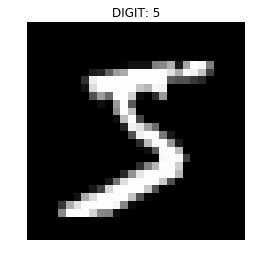

In [2]:
# MNIST Dataset (Images and Labels)
# If you have not mounted the dataset, you can download it
# just adding download=True as parameter
train_dataset = dsets.MNIST(root='/input', 
                            train=True, 
                            transform=transforms.ToTensor())
x_train_mnist, y_train_mnist = train_dataset.train_data.type(torch.FloatTensor), train_dataset.train_labels
test_dataset = dsets.MNIST(root='/input', 
                           train=False, 
                           transform=transforms.ToTensor())
x_test_mnist, y_test_mnist = test_dataset.test_data.type(torch.FloatTensor), test_dataset.test_labels

print('Training Data Size: ' ,x_train_mnist.size(), '-', y_train_mnist.size())
print('Testing Data Size: ' ,x_test_mnist.size(), '-', y_test_mnist.size())

plt.imshow(x_train_mnist[0].numpy(), cmap='gray')
plt.title('DIGIT: %i' % y_train_mnist[0])
plt.axis('off')
plt.show()

torch.utils.data.DataLoader combines a dataset and a sampler, and provides single or multi-process iterators over the dataset.

In [3]:
# Hyperparameter
batch_size = 8

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

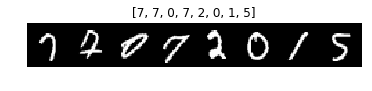

In [4]:
# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
trainset_iter = iter(train_loader)
images, labels = trainset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

### Convolutional Neural Network

...

In [6]:
# Hyperparameter
batch_size = 64

# Training Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Build the Model

We have defined in great details Neural Network. In the next snippet of code we will translate everything in PyTorch code.

In [8]:
# Hyperparameters
input_size = 784 # 28 * 28
hidden_size = 500
num_classes = 10
learning_rate = 1e-3

#### Model ####
# Convolutional Neural Network Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    
model = CNN(num_classes)

# If you are running a GPU instance, load the model on GPU
if cuda:
    model.cuda()
    

#### Loss and Optimizer ####
# Softmax is internally computed.
loss_fn = nn.CrossEntropyLoss()
# If you are running a GPU instance, compute the loss on GPU
if cuda:
    loss_fn.cuda()
    
# Set parameters to be updated.  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Train
We will train our model for 5 epochs and evaluate on test set.

In [10]:
# Hyperparameters
num_epochs = 5
print_every = 100

# Metrics
train_loss = []
train_accu = []

# Model train mode
model.train()
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # image unrolling
        images = Variable(images)
        labels = Variable(labels)
        
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Load loss on CPU
        if cuda:
            loss.cpu()
        loss.backward()
        optimizer.step()
        
        ### Keep track of metric every batch
        # Loss Metric
        train_loss.append(loss.data[0])
        # Accuracy Metric
        prediction = outputs.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(labels.data).sum()/batch_size*100
        train_accu.append(accuracy)
        
        # Log
        if (i+1) % print_every == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f, Accuracy: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0], accuracy))

Epoch: [1/5], Step: [100/937], Loss: 0.3449, Accuracy: 90.6250
Epoch: [1/5], Step: [200/937], Loss: 0.1222, Accuracy: 95.3125
Epoch: [1/5], Step: [300/937], Loss: 0.0907, Accuracy: 96.8750
Epoch: [1/5], Step: [400/937], Loss: 0.0311, Accuracy: 100.0000
Epoch: [1/5], Step: [500/937], Loss: 0.0467, Accuracy: 98.4375
Epoch: [1/5], Step: [600/937], Loss: 0.0659, Accuracy: 98.4375
Epoch: [1/5], Step: [700/937], Loss: 0.0240, Accuracy: 100.0000
Epoch: [1/5], Step: [800/937], Loss: 0.0256, Accuracy: 98.4375
Epoch: [1/5], Step: [900/937], Loss: 0.0170, Accuracy: 100.0000
Epoch: [2/5], Step: [100/937], Loss: 0.0298, Accuracy: 100.0000
Epoch: [2/5], Step: [200/937], Loss: 0.0195, Accuracy: 100.0000
Epoch: [2/5], Step: [300/937], Loss: 0.0396, Accuracy: 98.4375
Epoch: [2/5], Step: [400/937], Loss: 0.0282, Accuracy: 100.0000
Epoch: [2/5], Step: [500/937], Loss: 0.0406, Accuracy: 98.4375
Epoch: [2/5], Step: [600/937], Loss: 0.0070, Accuracy: 100.0000
Epoch: [2/5], Step: [700/937], Loss: 0.0795, Acc

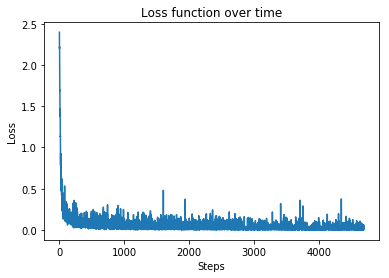

In [11]:
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss function over time")
plt.plot(np.arange(len(train_loss)), train_loss)

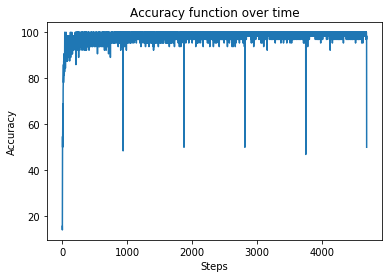

In [12]:
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Accuracy function over time")
plt.plot(np.arange(len(train_accu)), train_accu)

### Evaluate
Let's evaluate our model on test set.

In [14]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    if cuda:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    # Load output on CPU
    if cuda:
        output.cpu()
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))


Test set: Accuracy: 99.02%


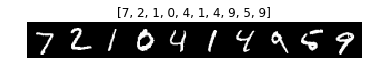

In [15]:
# Test Label

# Hyperparameter
batch_size = 10

# Testing Dataset Loader (Input Pipline)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Plot a grid of images
def imshow(inp_tensor, title):
    """image show for Tensor"""
    img = inp_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch
testset_iter = iter(test_loader)
images, labels = testset_iter.next()
# show images
batch_imgs = make_grid(images, nrow=batch_size)
plt.axis('off')
imshow(batch_imgs, title=[x for x in labels])

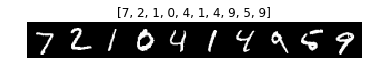

In [16]:
# Result from Training

input = Variable(images, volatile=True)
output = model(input)
# Load output on CPU
if cuda:
    output.cpu()
    
plt.axis('off')
imshow(batch_imgs, title=[x for x in output.data.max(1)[1]])

### Is it possible to do better?

TODO

### Summary

TODO

### It's you turn!

TODO

### Thanks and Resources

TODO